In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures, normalize
from scipy.stats import pearsonr

In [2]:
tab = pd.read_csv("temp_desL_init_subset.csv")

In [3]:
tab = tab.loc[:, ["h", "f", "l", "p", "r", "s", "vsSel"]]

In [4]:

pf = PolynomialFeatures(2, interaction_only = True)

In [5]:
X = np.array(tab.loc[:, ["h", "f", "l", "p", "r", "s"]])
X

array([[1, 4, 5, 9, 9, 9],
       [1, 4, 6, 9, 8, 9],
       [1, 4, 6, 9, 9, 9],
       ...,
       [9, 6, 1, 8, 2, 1],
       [9, 6, 1, 9, 1, 1],
       [9, 6, 1, 9, 2, 1]])

In [29]:
def expand_x(X):
    Xi = np.hstack([X] + [(X >= i) + 0 for i in np.arange(2, 10)])
    return Xi

Xi = expand_x(X)

In [12]:
ofs = ["h", "f", "l", "p", "r", "s"]
featnames1 = np.concatenate([ofs] + list([['I(' + of + '>=' + str(i) + ')' for i in np.arange(2, 10)] for of in ofs]))


In [13]:
#X2 = normalize(pf.fit_transform(Xi))
X2 = pf.fit_transform(Xi)
featnames2 = np.array(['*'.join(featnames1[np.nonzero(row)[0]]) for row in pf.powers_])
X2.shape


(34520, 1486)

In [14]:
y = tab.vsSel.values

In [15]:
n = len(y)
ntrain = int(n/2)
nval = int(n * .6)
nval

20712

In [16]:
from numpy.random import choice
perm = choice(n, n, replace = False)

In [17]:
Xtr = X2[perm[:ntrain]]
Xtv = X2[perm[ntrain:nval]]
Xte = X2[perm[nval:]]
ytr = y[perm[:ntrain]]
ytv = y[perm[ntrain:nval]]
yte = y[perm[nval:]]


In [18]:
from sklearn.linear_model import ElasticNet, LinearRegression

In [19]:
#lm = ElasticNet(alpha = 1e-3, l1_ratio = 1.0)
lm = LinearRegression(positive = True)

In [21]:
#lm.fit(Xtr, ytr)
lm.fit(np.vstack([Xtr, 1 * np.ones((1, Xtr.shape[1]))]),  np.concatenate([ytr, [0]]))

LinearRegression(positive=True)

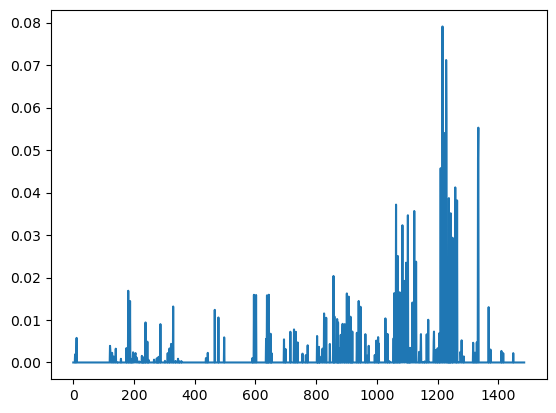

In [22]:
plt.plot(lm.coef_)

In [23]:
np.sum(lm.coef_ > 0)

197

In [24]:
lm.intercept_

-0.5289442982827391

In [25]:
pearsonr(ytv, lm.predict(Xtv))[0]

0.9151251170894901

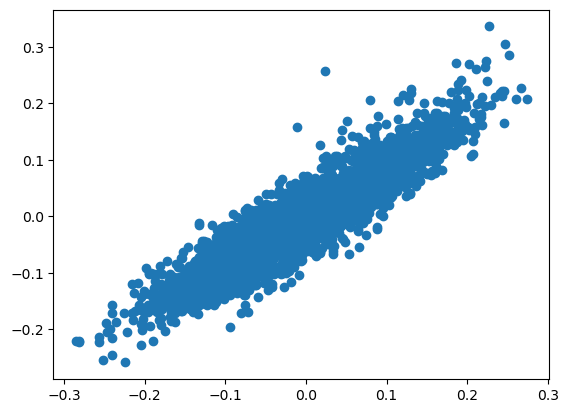

In [26]:
plt.scatter(ytv, lm.predict(Xtv))

In [27]:
pf.powers_.shape

(1486, 54)

In [28]:
pd.DataFrame({'feat':featnames2[lm.coef_ > 0], 'coef':lm.coef_[lm.coef_ > 0]}).to_csv("temp_desL_coefs.csv")

## interpret effects

In [115]:
order0_fx = lm.intercept_

In [130]:
# interpret effects by constructing test matrices
order1_fx = np.zeros((6, 10))
for i in range(6):
    test0 = np.zeros((10, 6))
    test0[:, i] = np.arange(10)
    testX = pf.fit_transform(expand_x(test0))
    order1_fx[i, :] = lm.predict(testX) - order0_fx

0

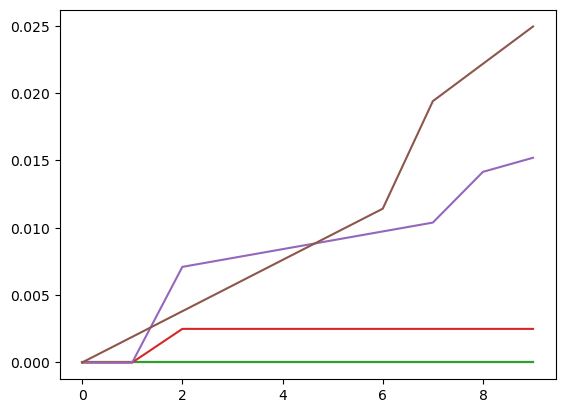

In [132]:
plt.plot(np.array(order1_fx).T)
0

In [133]:
order2_fx = np.zeros((6,6,10,10))

In [134]:
order2_fx.shape

(6, 6, 10, 10)

In [153]:
for i in range(6):
    for j in range(6):
        for v_i in range(1, 10):
            test0 = np.zeros((10, 6))
            test0[:, i] = v_i
            test0[:, j] = np.arange(10)
            testX = pf.fit_transform(expand_x(test0))
            order2_fx[i,j,v_i,:] = lm.predict(testX) - order0_fx - order1_fx[i, v_i] - order1_fx[j, :]

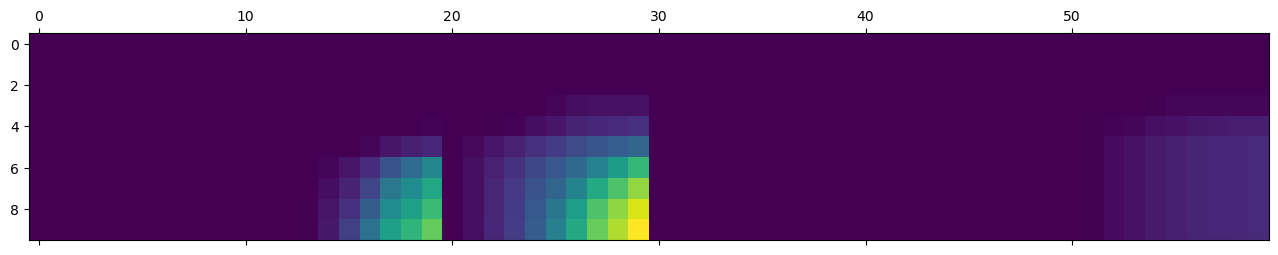

In [154]:
plt.matshow(np.hstack([order2_fx[0, i, :, :] for i in range(6)]))

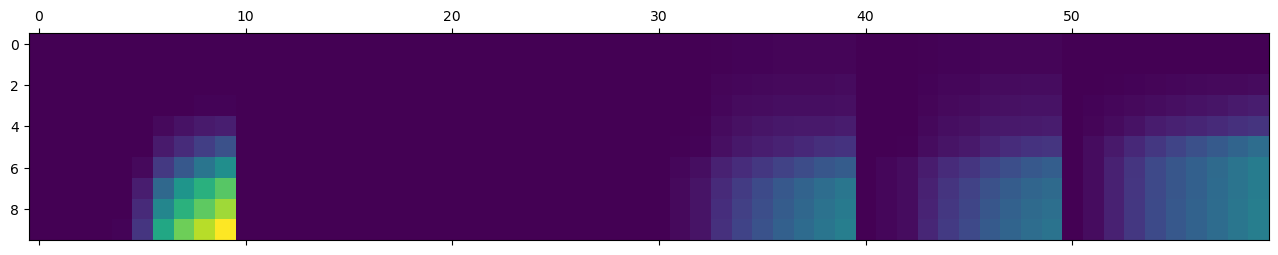

In [155]:
plt.matshow(np.hstack([order2_fx[1, i, :, :] for i in range(6)]))

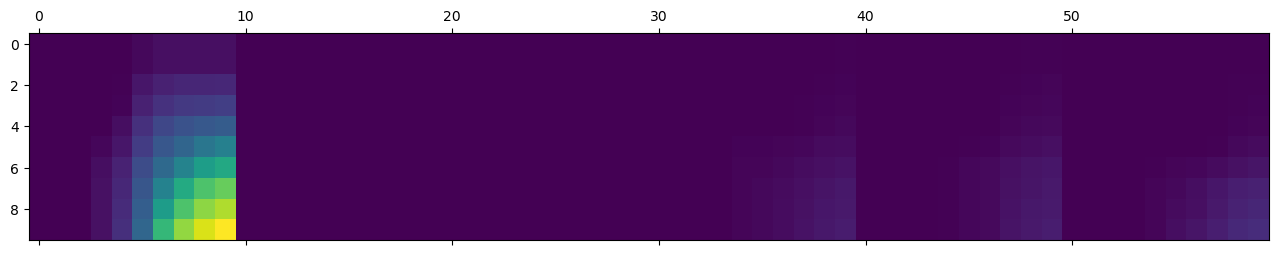

In [156]:
plt.matshow(np.hstack([order2_fx[2, i, :, :] for i in range(6)]))

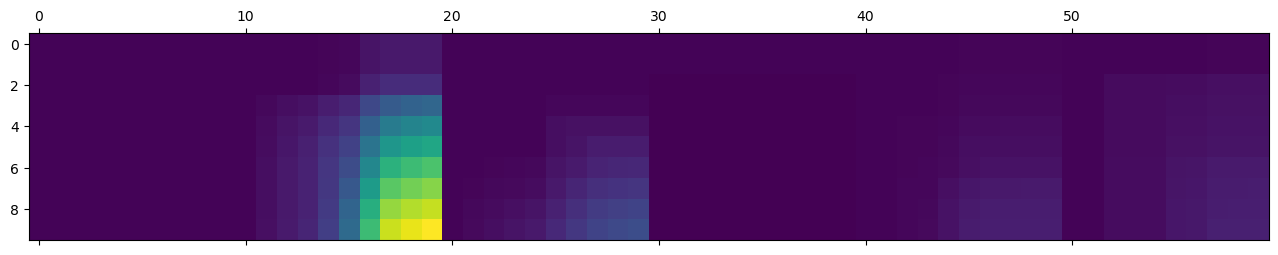

In [157]:
plt.matshow(np.hstack([order2_fx[3, i, :, :] for i in range(6)]))

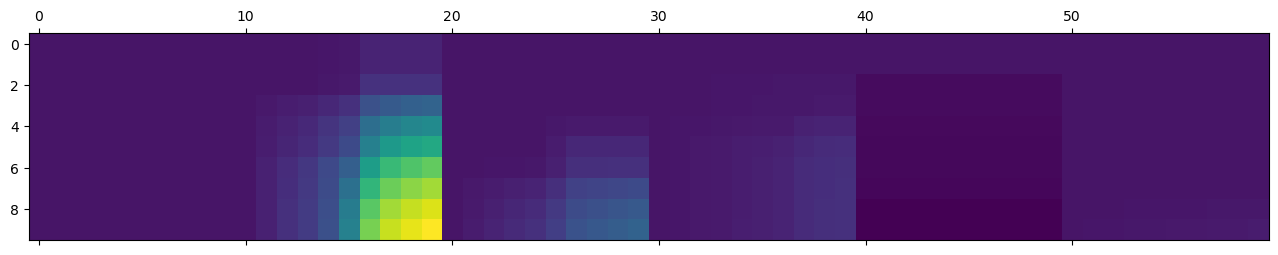

In [158]:
plt.matshow(np.hstack([order2_fx[4, i, :, :] for i in range(6)]))

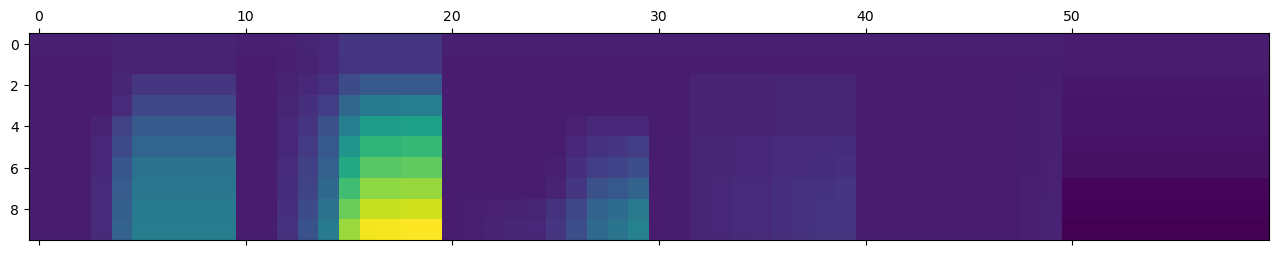

In [159]:
plt.matshow(np.hstack([order2_fx[5, i, :, :] for i in range(6)]))

In [171]:
i=0
j=2
test0 = np.zeros((10, 6))
test0[:, i] = np.arange(10)
test0[:, j] = np.arange(10)
testX = pf.fit_transform(expand_x(test0))
lm.predict(testX)

array([-0.5289443 , -0.5289443 , -0.5289443 , -0.5289443 , -0.49507756,
       -0.37187636, -0.22887291,  0.00581003,  0.19579554,  0.34556192])

In [172]:
test0

array([[0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [2., 0., 2., 0., 0., 0.],
       [3., 0., 3., 0., 0., 0.],
       [4., 0., 4., 0., 0., 0.],
       [5., 0., 5., 0., 0., 0.],
       [6., 0., 6., 0., 0., 0.],
       [7., 0., 7., 0., 0., 0.],
       [8., 0., 8., 0., 0., 0.],
       [9., 0., 9., 0., 0., 0.]])

In [173]:
order0_fx + order1_fx[i, :] + order1_fx[j, :] + np.array([order2_fx[i,j,k,k] for k in range(10)])

array([-0.5289443 , -0.5289443 , -0.5289443 , -0.5289443 , -0.49507756,
       -0.37187636, -0.22887291,  0.00581003,  0.19579554,  0.34556192])

In [174]:
i=0
j=1
l=2
test0 = np.zeros((10, 6))
test0[:, i] = np.arange(10)
test0[:, j] = np.arange(10)
test0[:, l] = np.arange(10)
testX = pf.fit_transform(expand_x(test0))
lm.predict(testX)

array([-0.5289443 , -0.5289443 , -0.5289443 , -0.5289443 , -0.49507756,
       -0.37187636, -0.1182918 ,  0.35411471,  0.69738628,  1.01316059])

In [175]:
test0

array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [2., 2., 2., 0., 0., 0.],
       [3., 3., 3., 0., 0., 0.],
       [4., 4., 4., 0., 0., 0.],
       [5., 5., 5., 0., 0., 0.],
       [6., 6., 6., 0., 0., 0.],
       [7., 7., 7., 0., 0., 0.],
       [8., 8., 8., 0., 0., 0.],
       [9., 9., 9., 0., 0., 0.]])

In [177]:
ans = order0_fx + order1_fx[i, :] + order1_fx[j, :]+ order1_fx[l, :]
ans = ans + np.array([order2_fx[i,j,k,k] for k in range(10)])
ans = ans + np.array([order2_fx[i,l,k,k] for k in range(10)])
ans = ans + np.array([order2_fx[j,j,k,k] for k in range(10)])
ans

array([-0.5289443 , -0.5289443 , -0.5289443 , -0.5289443 , -0.49507756,
       -0.37187636, -0.1182918 ,  0.35411471,  0.69738628,  1.01316059])

In [178]:
def predict_x(x, f0, f1, f2):
    s = f0
    for i in range(6):
        s += f1[i,int(x[i])-1]
    for i in range(5):
        for j in range(i+1, 6):
            s += f2[i,j,int(x[i]),int(x[j])]
    return s

In [186]:
lm.predict(Xtv)[:20]

array([-0.02388208, -0.06940331, -0.10729198,  0.03574873,  0.04567274,
       -0.066742  , -0.0921151 ,  0.12407526, -0.14584423, -0.08100413,
        0.0024262 , -0.04121913,  0.01152025,  0.14907822,  0.07143839,
        0.14360098,  0.13744837,  0.06747007, -0.08709547, -0.01088118])

In [188]:
np.array([predict_x(Xtv[i, 1:7], order0_fx, order1_fx, order2_fx) for i in range(20)])

array([-0.02683232, -0.0728339 , -0.11024222,  0.03318722,  0.0427225 ,
       -0.07017259, -0.09865552,  0.12151375, -0.14927482, -0.08754455,
       -0.00034638, -0.04378065,  0.00895874,  0.14717471,  0.0680078 ,
        0.13854496,  0.13401779,  0.06490856, -0.08965698, -0.01655253])

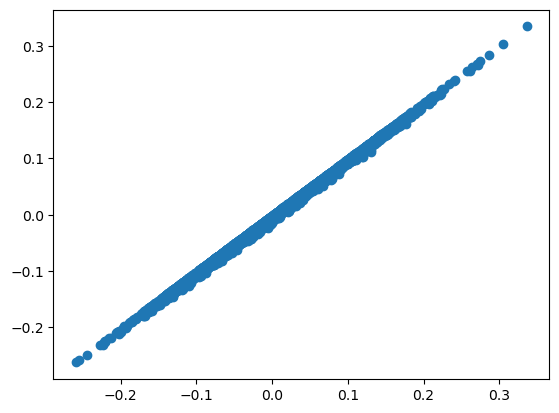

In [205]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]))

## Try discretization

In [239]:
delta = 0.01

In [240]:
f0 = np.floor(order0_fx/delta) * delta
f1 = np.floor(order1_fx/delta) * delta
f2 = np.floor(order2_fx/delta) * delta


0

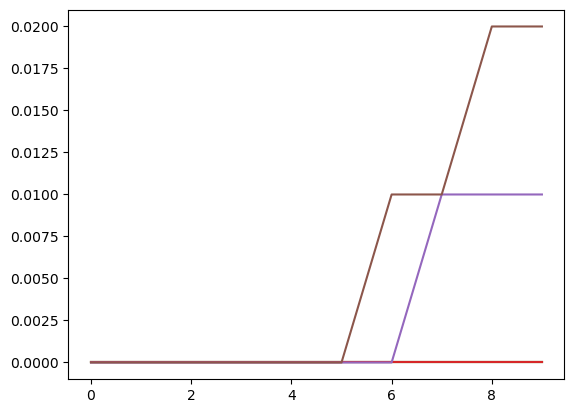

In [241]:
plt.plot(np.arange(0, 10), np.array(f1).T)
0

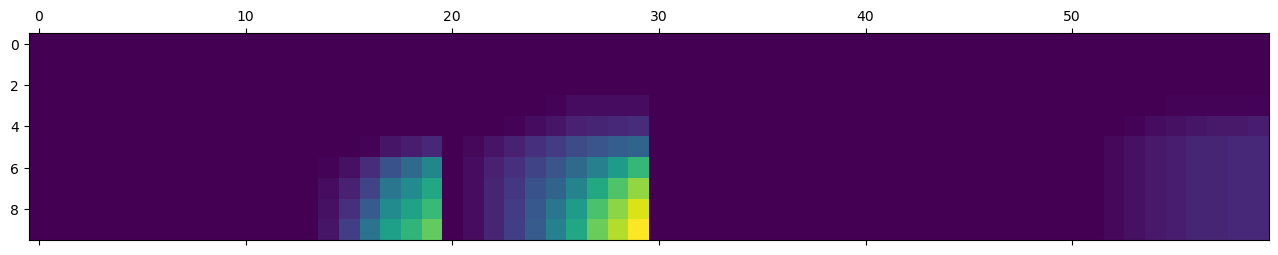

In [242]:
plt.matshow(np.hstack([f2[0, i, :, :] for i in range(6)]))

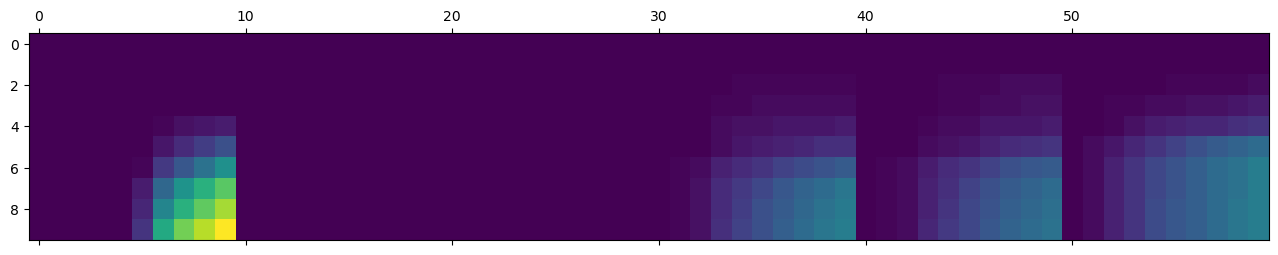

In [243]:
plt.matshow(np.hstack([f2[1, i, :, :] for i in range(6)]))

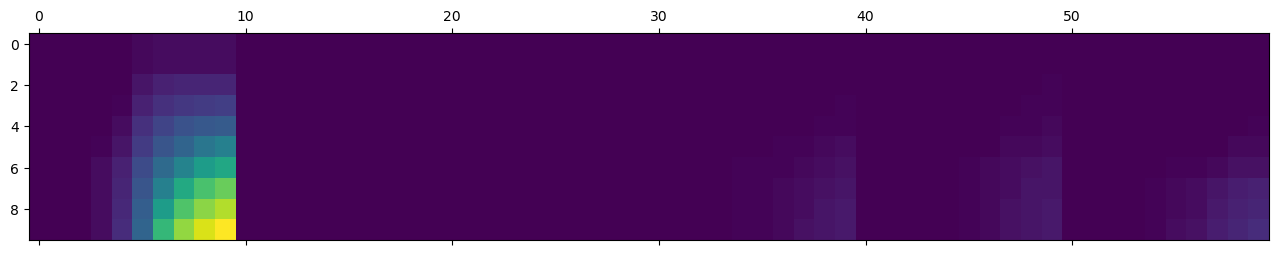

In [244]:
plt.matshow(np.hstack([f2[2, i, :, :] for i in range(6)]))

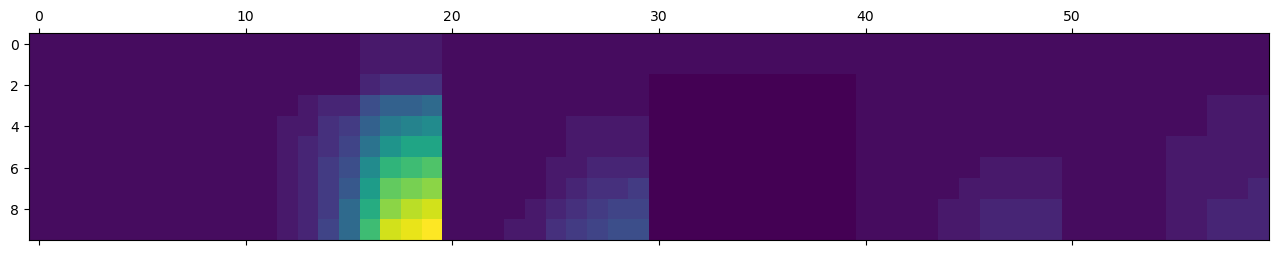

In [245]:
plt.matshow(np.hstack([f2[3, i, :, :] for i in range(6)]))

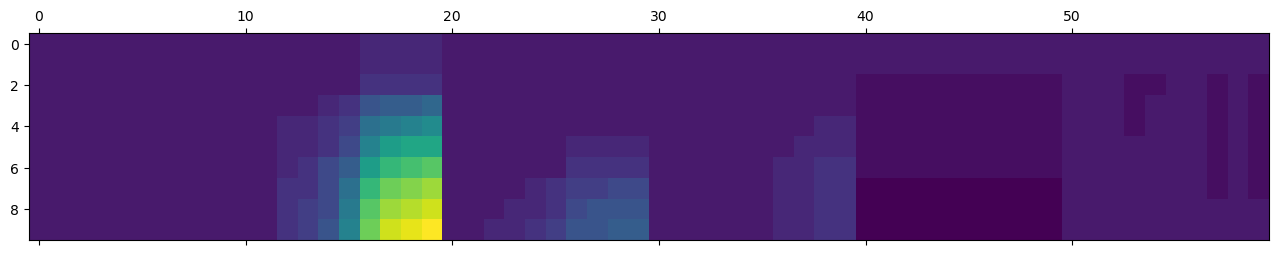

In [246]:
plt.matshow(np.hstack([f2[4, i, :, :] for i in range(6)]))

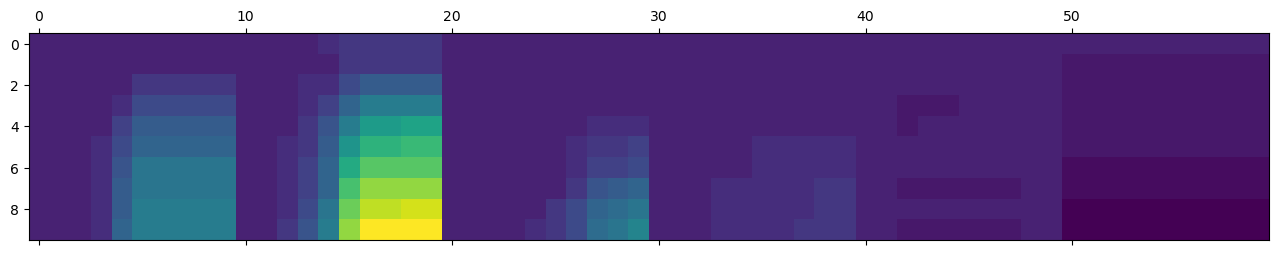

In [247]:
plt.matshow(np.hstack([f2[5, i, :, :] for i in range(6)]))

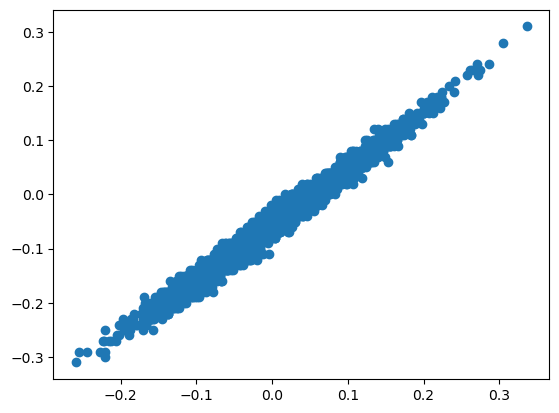

In [248]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))

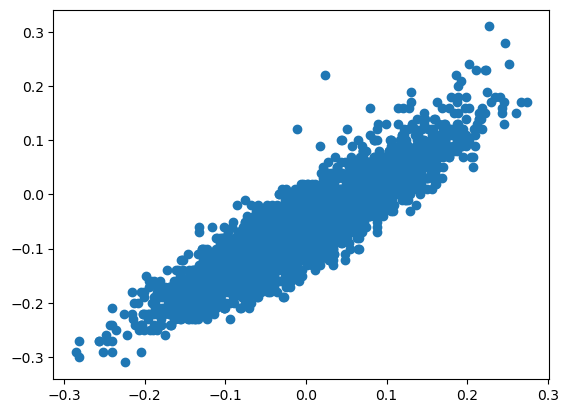

In [249]:
plt.scatter(ytv, np.array([predict_x(Xtv[i, 1:7], f0, f1, f2) for i in range(len(Xtv))]))